Research on DDPG's use on portfolio managment

In [20]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from enviroment import Simulate_Portfolio
from datetime import datetime, timedelta
import keras
import yfinance as yf

Creating Portfolio/Enviroment

In [21]:
""""Setting length of training and the timestep interval"""
interval_hrs = 1
training_length = timedelta(
    days=364,
    hours=0,
)

validation_length = timedelta(
    days=0,
    hours=0,
)

testing_length = timedelta(
    days=100,
    hours=0,
)

interval_length = timedelta(
    days=0,         
    hours=interval_hrs,
    minutes=0
)
"""Each epsiode will be from training_start to training_end"""
training_start = datetime.now() - training_length - validation_length - testing_length
training_end = training_start + training_length

"""Currently won't "be using validation, but will 
be useful in the future for more complex training schedules"""
validation_start = training_end
validation_end = validation_start + validation_length

testing_length_start = validation_end
testing_length_end = testing_length_start + testing_length


print("Training from ", training_start, " to ", training_end)

Training from  2024-07-16 15:23:32.206719  to  2025-07-15 15:23:32.206719


In [22]:
print(datetime.now())

2025-10-23 15:23:32.224240


In [29]:
"""Experimentation on pandas"""

name = 'MSFT'

test_portfolio_daily = Simulate_Portfolio(training_start, 100, 24)
test_portfolio_daily.add_investment('MSFT')
test_portfolio_hourly = Simulate_Portfolio(training_start, 100, 1)
test_portfolio_hourly.add_investment('MSFT')



Using interval string: 1d
Using interval string: 1h


In [24]:

timesteps_h = test_portfolio_hourly.investments_timesteps[name]
print(timesteps_h)
future_timesteps_h = test_portfolio_hourly.investments_future_steps[name]
print(future_timesteps_h)

[np.float64(447.8699951171875)]
Datetime
2024-07-16 14:30:00-04:00    449.559998
2024-07-16 15:30:00-04:00    449.489990
2024-07-17 09:30:00-04:00    441.130005
2024-07-17 10:30:00-04:00    441.170013
2024-07-17 11:30:00-04:00    440.440002
                                ...    
2025-10-22 12:30:00-04:00    520.554626
2025-10-22 13:30:00-04:00    519.330017
2025-10-22 14:30:00-04:00    520.010010
2025-10-22 15:30:00-04:00    520.479980
2025-10-23 09:30:00-04:00    521.200012
Name: Close, Length: 2224, dtype: float64


In [25]:
timesteps_d = test_portfolio_daily.investments_timesteps[name]
print(timesteps_d)
future_timesteps_d = test_portfolio_daily.investments_future_steps[name]
print(future_timesteps_d)

[np.float64(445.3676452636719)]
Date
2024-07-16 00:00:00-04:00    445.367615
2024-07-17 00:00:00-04:00    439.423035
2024-07-18 00:00:00-04:00    436.302155
2024-07-19 00:00:00-04:00    433.072235
2024-07-22 00:00:00-04:00    438.848389
                                ...    
2025-10-17 00:00:00-04:00    513.580017
2025-10-20 00:00:00-04:00    516.789978
2025-10-21 00:00:00-04:00    517.659973
2025-10-22 00:00:00-04:00    520.539978
2025-10-23 00:00:00-04:00    521.200012
Name: Close, Length: 321, dtype: float64


In [26]:
val_h, time_h = test_portfolio_hourly.get_current_timestep_sim_h(name)


print("Hourly data at time ", time_h, " is ", val_h)

Hourly data at time  2024-07-16 15:30:00-04:00  is  449.489990234375


In [27]:
val_d, time_d = test_portfolio_daily.get_current_timestep_sim_d(name)


print("Daily data at time ", time_d, " is ", val_d)

Daily data at time  2024-07-16 15:23:32.206719  is  445.36761474609375


In [28]:
val_h, time_h = test_portfolio_hourly.get_current_timestep_sim(name)
val_d, time_d = test_portfolio_daily.get_current_timestep_sim(name)

print("Hourly data at time ", time_h, " is ", val_h)
print("Daily data at time ", time_d, " is ", val_d)

TypeError: Invalid comparison between dtype=datetime64[ns, America/New_York] and Timestamp

In [ ]:
assert False, "Stop here"

Supporting Functions

In [ ]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
            
            
            


def policy(state, noise_obj, actor):

    sampled_actions = keras.ops.squeeze(actor(state))
    noise = noise_obj()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1, 1)
    return legal_action # [np.squeeze(legal_action)]

def return_state(portfolio):
    state = np.array(portfolio.return_all_states())
    state = np.concatenate((state.flatten(), [portfolio.balance]), axis=None)
    return state

def reset_enviroment(date):
    
    porfolio = Simulate_Portfolio(date, 100, interval_hrs)
    for name in names:
        porfolio.add_investment(name)

    initial_state = return_state(porfolio)

    return initial_state, porfolio

def perform_action(actions, portfolio, prev_state):
    # :: action, portfolio, prev_state -> state, reward

    prev_state = np.array(portfolio.return_all_states())
    balance = portfolio.balance
    holdings = prev_state[:,1]

    
    increasing = np.amax(np.concatenate(([actions], [np.zeros(len(actions))]), axis=0), axis=0)
    decreasing = np.amin(np.concatenate(([actions+1], [np.ones(len(actions))]), axis=0), axis=0)

    prev_net = portfolio.get_portfolio_net()

    #pre_any_increases
    new_holdings = holdings * decreasing 

    for i, holding in enumerate(new_holdings):
        if actions[i] < 0:
            try:
                portfolio.update_investment(names[i], round(holding, 6))
            except:
                raise ValueError(f"Value update not possible, '\n' tried increasing {names[i]} to {holding}, was {holdings[i]}, action: {actions[i]}, \n balance:{portfolio.balance}, state:{prev_state}")

    balance = portfolio.balance
    if np.sum(increasing) > 0:
        new_holdings += balance * (increasing**2)/np.sum(increasing)

    for i, holding in enumerate(new_holdings):
        if actions[i] > 0:
            try:
                portfolio.update_investment(names[i], round(holding, 6))
            except:
                raise ValueError(f"Value update not possible, '\n' tried increasing {names[i]} to {holding}, was {holdings[i]}, action: {actions[i]}, \n balance:{balance}, state:{prev_state}")
            
    portfolio.next_timestep()
    
    reward = portfolio.get_portfolio_net() - prev_net
    return return_state(portfolio), reward, holdings - new_holdings

def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)
    

Create Models

In [ ]:
from keras import layers
from tensorflow.keras.layers import LeakyReLU

def get_actor():

    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(64)(inputs)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    model = keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    state_input = layers.Input(shape=(num_states,))
    out = layers.Dense(64)(state_input)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    state_out = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through separate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(128)(concat)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(128)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(128, activation="sigmoid")(out)
    outputs = layers.Dense(1)(out)
    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model


In [ ]:
std_dev = 0.15
ou_noise = OUActionNoise(mean=np.zeros(num_actions), std_deviation=float(std_dev) * np.ones(num_actions))
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())


# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)


# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.001

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
class Buffer:
    def __init__(self, models, buffer_capacity=100_000, batch_size=64, episode_size=1508):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        self.previous_critic_scores = []

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
        
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training = True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training = True)
            
            critic_value = critic_model([state_batch, action_batch], training = True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))
            
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training = True)
            critic_value = critic_model([state_batch, actions], training = True)
           # self.previous_critic_scores.append(keras.ops.squeeze(critic_value))
            actor_loss = -keras.ops.mean(critic_value)
            
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
    def learn(self):
        
        record_range = min(self.buffer_counter, self.buffer_capacity)
        
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)




In [ ]:
total_episodes = 10
print(f"Training run from {training_start} to {training_end} with {total_episodes} episodes")


Training run from 2025-06-21 02:50:24.076742 to 2025-09-20 08:50:24.076742 with 10 episodes


In [ ]:



buffer = Buffer(50000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

start_time = training_start
end_time = training_end
ep_profit = []
all_states = []
all_actions = []
    
for ep in range(total_episodes):
    
    prev_state, porfolio = reset_enviroment(training_start)
    episodic_reward = 0
    step = 0
    ep_start = datetime.now()
    episodic_actions = []
    episodic_val_diff = []
    episodic_timesteps = []
    episodic_full_state = []

    print(f"Starting episode: {ep}, with datetime {porfolio.datetime.strftime('%d-%m-%Y')}, ending at {end_time.strftime('%d-%m-%Y')}, state: {prev_state}")
    
    while porfolio.datetime < end_time:
        
        tf_prev_state = keras.ops.expand_dims(
            keras.ops.convert_to_tensor(prev_state), 0
        )
        
        action = policy(tf_prev_state, ou_noise, actor_model)
        
        state, reward, value_change = perform_action(action, porfolio, prev_state)
        assert False
                
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        
        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        episodic_actions.append(action)
        episodic_val_diff.append(value_change)
        episodic_full_state.append([prev_state])

        prev_state = state 

        step+=1

    all_states.append(episodic_full_state)
    ep_reward_list.append(episodic_reward)
    
    ep_profit.append(porfolio.calc_profit())
    
    avg_reward = np.mean(ep_reward_list[-40:])
    
    ep_end = datetime.now()
    elapsed = ep_end - ep_start
    minutes, seconds = divmod(elapsed.total_seconds(), 60)
    try:
        print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")
    except:
        print(f"Episode {ep}, with avarage {episodic_reward, step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")

    print(f"Episode profit -- start: {porfolio.init_balance}, end: {porfolio.get_portfolio_net()}, profit: {porfolio.calc_profit()}")
    print(f"Episode actions -- avg action: {np.mean(episodic_actions)}, latest:{np.mean(episodic_actions[-40:])}")
    print(f"Episodic value changes -- reward: {episodic_reward} avg change: {np.mean(episodic_val_diff)}, latest:{np.mean(episodic_val_diff[-40:])} \n")
    print(f"Ending state: {state}, datetime: {porfolio.datetime.strftime('%d-%m-%Y')}\n")
    avg_reward_list.append(avg_reward)
    all_actions.append(episodic_actions)


Using interval string: 1h
Starting episode: 0, with datetime 21-06-2025, ending at 20-09-2025, state: [477.22750854   0.         166.69000244   0.         209.604599
   0.         200.94000244   0.         100.        ]


TypeError: Invalid comparison between dtype=datetime64[ns, America/New_York] and Timestamp

Display and Interpret Training Results

In [ ]:
all_states = np.array(all_states)
print(all_states.shape)
all_states = np.squeeze(all_states)
print(all_states.shape)


balances = all_states[:, :, -1]

msft_price = all_states[:, :, 0]
googl_price = all_states[:, :, 2]
msft_holdings = all_states[:, :, 1]
googl_holdings = all_states[:, :, 3]

(10, 375, 1, 9)
(10, 375, 9)


In [ ]:
def display_episode(ep):
    # plt.plot(balances[ep], label="Balance")
    # plt.title(f"Episode {ep} Balance over time")

    for i, name in enumerate(names):

        plt.plot(all_states[:,:,2*i][ep] , label=f"{name} Price")
        plt.plot(all_states[:,:,2*i +1][ep] , label=f"{name} Holdings")

    # plt.plot(msft_holdings[ep], label="MSFT Holdings")
    # plt.plot(googl_holdings[ep], label="GOOGL Holdings")
    plt.title(f"Episode {ep} Stock Holdings over time")
    plt.legend()
    plt.grid(True)



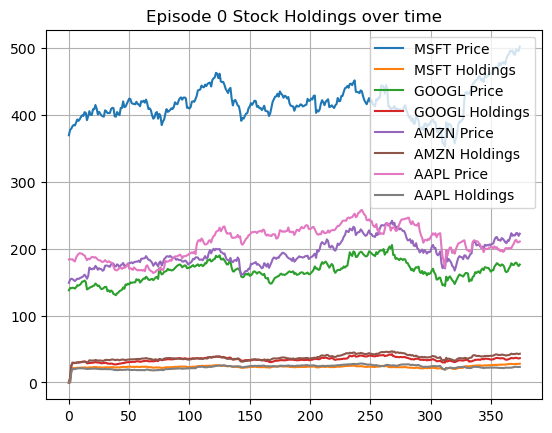

In [ ]:
display_episode(0)

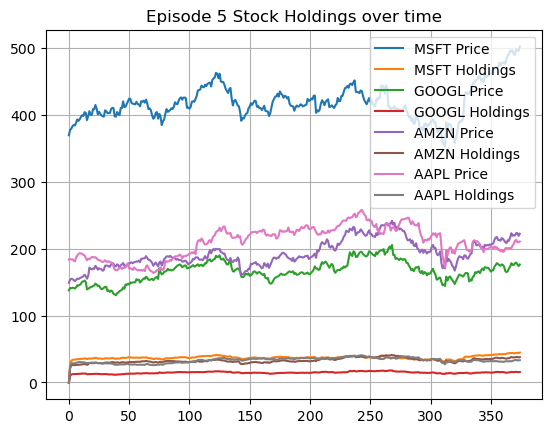

In [ ]:
display_episode(5)

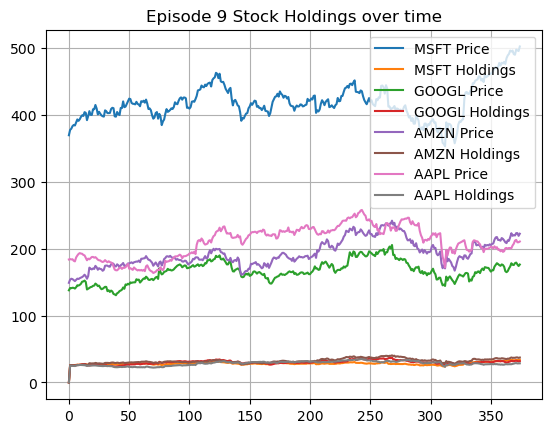

In [ ]:
display_episode(9)

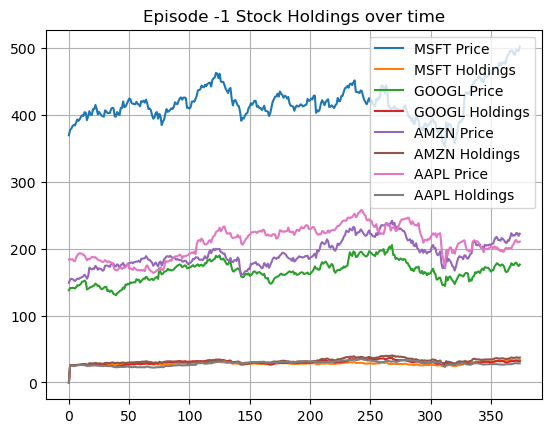

In [ ]:
display_episode(-1)

In [ ]:
actions = np.array(all_actions)

In [ ]:
def display_actions(ep):
    for i, name in enumerate(names):
        plt.plot(actions[ep,:,i], label=f"{name} Action")
    plt.title(f"Episode {ep} Actions over time")
    plt.xlabel("Step")
    plt.ylabel("Action")
    plt.legend()

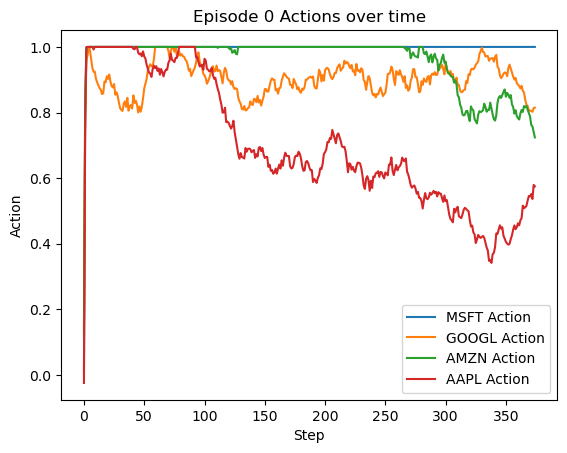

In [ ]:

display_actions(0)

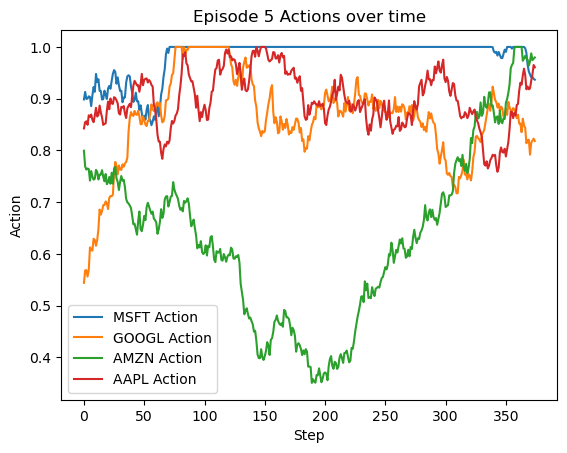

In [ ]:
display_actions(5)

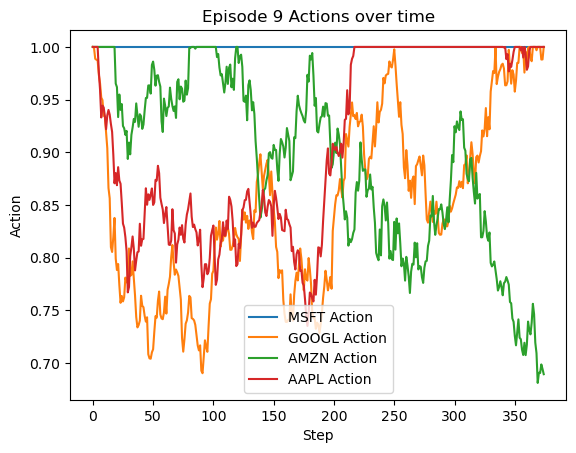

In [ ]:
display_actions(9)